
### Objective: 

In this assignment, implement the Node2Vec algorithm, a random-walk-based GNN, to learn node embeddings. Train a classifier using the learned embeddings to predict node labels.

### Dataset: 

Cora dataset: The dataset consists of 2,708 nodes (scientific publications) with 5,429 edges (citations between publications). Each node has a feature vector of size 1,433, and there are 7 classes (research topics).
Skeleton Code:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from node2vec import Node2Vec  # Importing Node2Vec for the random walk

# Load the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora')

# Prepare data
data = dataset[0]

# Convert to networkx for random walk
import networkx as nx
G = to_networkx(data, to_undirected=True)

# Node2Vec configuration
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=2) 
# model = node2vec.fit(window=10, min_count=1)
model = node2vec.fit(window=10, min_count=1, vector_size=64)

# Embeddings for each node
embeddings = model.wv  # Node embeddings

# Define a simple classifier
class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

# Initialize classifier and optimizer
classifier = Classifier(64, 7)
optimizer = optim.Adam(classifier.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

original_loss = []

# Training loop
for epoch in range(100):
    classifier.train()
    optimizer.zero_grad()
    
    # Get node embeddings as input
    output = classifier(torch.tensor([embeddings[str(i)] for i in range(data.num_nodes)]))
    
    loss = criterion(output, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        original_loss.append(loss.item())

print("Training complete!")


Generating walks (CPU: 2): 100%|██████████| 100/100 [02:23<00:00,  1.43s/it]
/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_88283/1411892068.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788637225/work/torch/csrc/utils/tensor_new.cpp:281.)
  output = classifier(torch.tensor([embeddings[str(i)] for i in range(data.num_nodes)]))


Epoch 0, Loss: 3.0836739540100098
Epoch 10, Loss: 0.9797987341880798
Epoch 20, Loss: 0.8204363584518433
Epoch 30, Loss: 0.7555112242698669
Epoch 40, Loss: 0.7229706645011902
Epoch 50, Loss: 0.7069429755210876
Epoch 60, Loss: 0.6987252831459045
Epoch 70, Loss: 0.6932913661003113
Epoch 80, Loss: 0.6893656849861145
Epoch 90, Loss: 0.6862888932228088
Training complete!


In [3]:
# original_loss = [3.0836739540100098, 0.9797987341880798, 0.8204363584518433,
#                  0.7555112242698669, 0.7229706645011902, 0.7069429755210876, 
#                  0.6987252831459045, 0.6932913661003113, 0.6893656849861145,
#                  0.6862888932228088]

## Explanation:
Node2Vec generates node embeddings by simulating random walks on the graph. These walks capture structural properties of nodes.
The generated embeddings are then used to train a classifier for predicting node labels.
The Cora dataset is a benchmark graph where nodes are papers and edges are citations.

## Questions (1 point each):

Notes:
1. Generate multiple biased random walk for each node.
    - Analogy to NLP: sequence -> NLP sentence, node -> word, neighborhood -> context
2. Skim-gram, maximize probability of seeing context nodes for target nodes.
3. Objective function: $$\sum_{u \in V} \sum_{v \in N_s(u)} \log P(v|u)$$
    - Node2Vec aim to maximize the objective function for all nodes.
    - $V$ is the set of all nodes, $N_s(u)$ is the neighborhood of $u$, $P(v|u)$ is the probability of context node $v$ given $u$.
    - $P(v|u)$ is approximated with softmax: $P(v|u) = \frac{\exp(z_v \cdot z_u)}{\sum_{v' \in V} \exp(z_v' \cdot z_u)}$
4. Negative sampling optimization: used to approximate softmax for all nodes.
    - For each positive context node $v$, a few negative samples (nodes that are not in context of $u$) are drawn. The model maximizes the probability of $v$ while minimizing the probability of sample nodes. 
5. Backpropagation and update

In [5]:
import matplotlib.pyplot as plt

#### 1. What would happen if we increased the number of walks (num_walks) per node? How might this affect the learned embeddings?

If we increase the number of walks per node, there will be more data about each node's neighborhood as more node sequences will be produced. 

The model may learn the embeddings of a node better as it is provided with more context information about the node's neighborhood. However, the training cost will increase and there is also a potential for overfitting. 

In [6]:
# increase number of walks
node2vec_more_walks = Node2Vec(G, dimensions=64, walk_length=30, num_walks=400, workers=2)
model_more_walks = node2vec_more_walks.fit(window=10, min_count=1, vector_size=64)

embeddings_more_walks = model_more_walks.wv

classifier_more_walks = Classifier(64, 7)
optimizer_more_walks = optim.Adam(classifier_more_walks.parameters(), lr=0.01)

Generating walks (CPU: 1): 100%|██████████| 200/200 [05:51<00:00,  1.76s/it]


In [7]:
loss_more_walks = []

for epoch in range(100):
    classifier_more_walks.train()
    optimizer_more_walks.zero_grad()
    
    output_high_walks = classifier_more_walks(torch.tensor([embeddings_more_walks[str(i)] for i in range(data.num_nodes)]))
    
    loss = criterion(output_high_walks, data.y)
    loss.backward()
    optimizer_more_walks.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss (More Walks): {loss.item()}')
        loss_more_walks.append(loss.item())

Epoch 0, Loss (More Walks): 3.2086994647979736
Epoch 10, Loss (More Walks): 0.9668700098991394
Epoch 20, Loss (More Walks): 0.7830494046211243
Epoch 30, Loss (More Walks): 0.723023533821106
Epoch 40, Loss (More Walks): 0.6963661313056946
Epoch 50, Loss (More Walks): 0.6798729300498962
Epoch 60, Loss (More Walks): 0.671376645565033
Epoch 70, Loss (More Walks): 0.6658375859260559
Epoch 80, Loss (More Walks): 0.6619228720664978
Epoch 90, Loss (More Walks): 0.6588699817657471


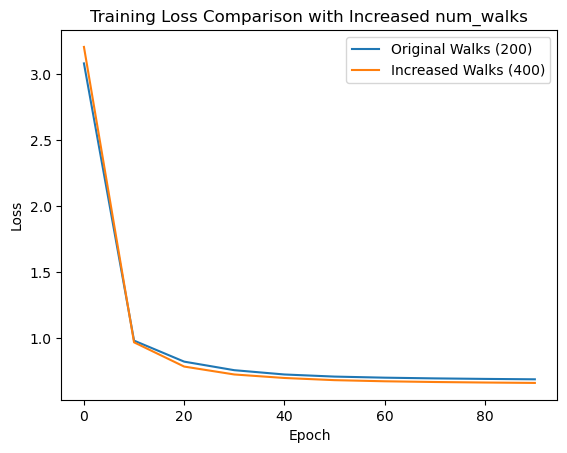

In [8]:
epochs = range(0, 100, 10)

plt.plot(epochs, original_loss, label="Original Walks (200)")
plt.plot(epochs, loss_more_walks, label="Increased Walks (400)")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison with Increased num_walks')
plt.legend()
plt.show()

#### 2. What would happen if we reduced the walk length (walk_length)? How would this influence the structural information captured by the embeddings?


If we reduce the walk length, the distance of random walks from each node is restricted. Longer node sequences are not included in the model training process, which make the embeddings more reflective of local information instead of broader ones. 

This will affect the model's ability to learn global graph structure. The model may focus more on the local context and capture more details about local community structure.

In [9]:
# reduce walk length
node2vec_short_walks = Node2Vec(G, dimensions=64, walk_length=15, num_walks=200, workers=2)
model_short_walks = node2vec_short_walks.fit(window=10, min_count=1, vector_size=64)

embeddings_short_walks = model_short_walks.wv

classifier_short_walks = Classifier(64, 7)
optimizer_short_walks = optim.Adam(classifier_short_walks.parameters(), lr=0.01)

Generating walks (CPU: 2): 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


#### 3. What would happen if we used directed edges instead of undirected edges for the random walks?


Using directed edges means that the walks must follow certain directions on each edge, which can significantly restrict the possible walk paths. The model will learn directional structures instead of undirected ones. However, it may miss some details about the global context that an undirected model can capture.

#### 4. What would happen if we added more features to the nodes (e.g., 2000-dimensional features instead of 1433)?


Adding more features to the nodes may provide more information about the nodes, allowing the model to learn more details. The model's performance may improve as it captures more subtle differences among the nodes. However, there is also a risk for overfitting and the training time will increase. 

#### 5. What would happen if we used a different dataset with more classes? Would the classifier performance change significantly?


Using another dataset with more classes may decrease the classifier's performance as there are more possible classification targets. The model have to learn more diversity within the provided nodes to be able to distinguish among different classes.

#### 6. What would happen if we used a larger embedding dimension (e.g., 128 instead of 64)? How would this affect the model’s performance and training time?


Using a larger embedding dimension would increase the model's training time as well as needed memory as more computation is needed. However, it may improve the model's performance as it may increase the model's capacity to learn the complex relationships between nodes better, thus to better learn the graph structure.  

### Extra credit: 


#### 1. What would happen if we increased the window size (window) for the skip-gram model? How would it affect the embedding quality?


The window size determines the number of nodes considered as context (or neighbor) nodes for one node. If we increase the window size for the skip-gram model, the model may consider larger neighborhoods around each target node. This may allow the model to learn more about the global structure of the graph, while focus less on the local details. 

The embedding quality may decrease since more nodes are considered neighbors and more initial variations will be included into the embedding learning process. This will also increase the computational cost and training time.

potentially make the embeddings more generalized

## No points, just for you to think about

#### 1. What would happen if we removed self-loops from the graph before training Node2Vec?


#### 2. What would happen if we applied normalization to the node embeddings before feeding them to the classifier?